In [24]:
from offline_playback import process_stroke, replay_data, merge_data, get_black_points, normalize_points
import numpy as np
from PIL import Image
import pickle

recording_timestamp = "20230905_162344"
savefig_kwargs = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0}

scan_img = Image.open(f"./recordings/{recording_timestamp}/scan.jpg")
scan_dpi, _ = scan_img.info.get("dpi")
scan_x, scan_y = get_black_points(np.asarray(scan_img), scan_dpi)
scan_points = normalize_points(np.column_stack((scan_x, scan_y)))

def load_and_process(stylus_data_fname, camera_data_fname):
    with open(
        f"./recordings/{recording_timestamp}/{stylus_data_fname}", "rb"
    ) as pickle_file:
        stylus_data = pickle.load(pickle_file)
    with open(
        f"./recordings/{recording_timestamp}/{camera_data_fname}", "rb"
    ) as pickle_file:
        camera_data = pickle.load(pickle_file)
    recorded_data = merge_data(stylus_data, camera_data)
    tip_pos_predicted, tip_pos_smoothed, pressure = replay_data(recorded_data)
    tpp = process_stroke(tip_pos_predicted, scan_points, pressure)
    tps = process_stroke(tip_pos_smoothed, scan_points, pressure)
    return tpp, tps

tpp, tps = load_and_process("stylus_data.pkl", "camera_data.pkl")

sample_count: 4627
Resetting state, errors: 0.28229554569920684, 1.1370123937020913


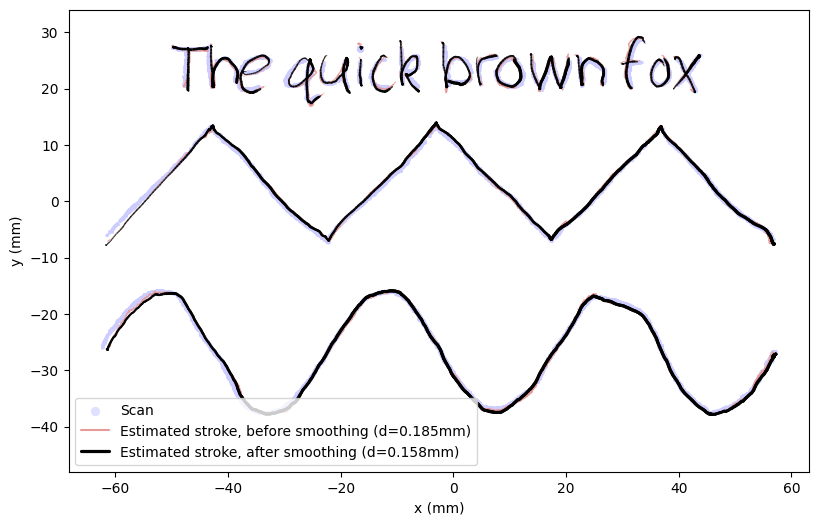

In [38]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import seaborn as sns

from offline_playback import ProcessedStroke

%matplotlib inline

def stroke_to_linecollection(stroke: ProcessedStroke, width, color):
    xy = stroke.position * 1000
    x, y = xy[:, 0], xy[:, 1]
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    lc = LineCollection(segments)
    pressure_clip = np.clip(stroke.pressure, 0, 1)
    lc.set_linewidth((pressure_clip**0.7) * width)
    # alpha = np.sqrt(pressure_clip)[:,np.newaxis]
    # color_vec = np.array(color,  dtype=float) * alpha + (1 - alpha)
    lc.set_alpha(pressure_clip**0.3)
    lc.set_color(color)
    lc.set_rasterized(True)
    lc.set_capstyle("round")
    proxy = Line2D([0, 1], [0, 1], color=color, lw=width, solid_capstyle="round")
    return lc, proxy

def plot_scan_points(scan_points):
    ax: Axes = sns.scatterplot(
        x=scan_points[:, 0] * 1000,
        y=scan_points[:, 1] * 1000,
        color=(0.8, 0.8, 1),
        s=5,
        alpha=0.6,
        linewidth=0,
    )
    ax.set_aspect("equal")
    ax.set(xlabel="x (mm)", ylabel="y (mm)", ylim=(-48,34))
    ax.collections[0].set_rasterized(True)
    return ax

def plot_strokes(ax, tpp, tps):
    lc1, lc1_proxy = stroke_to_linecollection(tpp, 1.5, color=(0.9, 0.6, 0.6))
    ax.add_collection(lc1)
    lc2, lc2_proxy = stroke_to_linecollection(tps, 2.3, color=(0, 0, 0))
    ax.add_collection(lc2)
    ax.legend(
        [ax.collections[0], lc1_proxy, lc2_proxy],
        [
            "Scan",
            f"Estimated stroke, before smoothing (d={tpp.dist_mean*1000:0.3f}mm)",
            f"Estimated stroke, after smoothing (d={tps.dist_mean*1000:0.3f}mm)",
        ],
        loc="lower left",
        markerscale=3,
    )


fig = plt.figure()
fig.set_size_inches(100,6)
ax = plot_scan_points(scan_points)
plot_strokes(ax, tpp, tps)

# plt.savefig(f"./recordings/{recording_timestamp}/main-sketch-plot.pdf", **savefig_kwargs)

In [61]:
def mini_plot(tpp, tps, noleftlabels=False):
    fig = plt.figure(figsize=(100,4.3))
    ax = plot_scan_points(scan_points)
    plot_strokes(ax, tpp, tps)
    ax.set(ylim=(-62, 34))
    if noleftlabels:
        ax.set(ylabel=None, yticklabels=[])
    return ax

In [ ]:
nomarkercalib = load_and_process("stylus_data.pkl", "camera_data_nomarkercalib.pkl")
norsc = load_and_process("stylus_data.pkl", "camera_data_norsc.pkl")
epnp = load_and_process("stylus_data.pkl", "camera_data_epnp.pkl")
sqpnp = load_and_process("stylus_data.pkl", "camera_data_sqpnp.pkl")

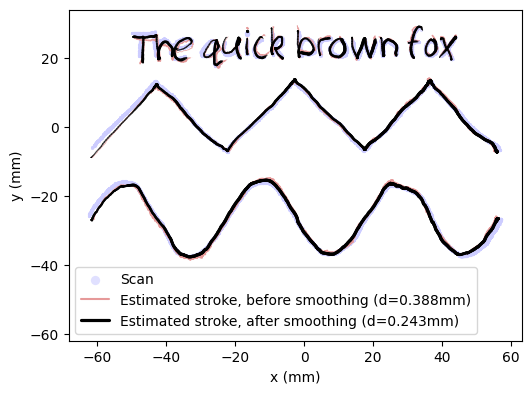

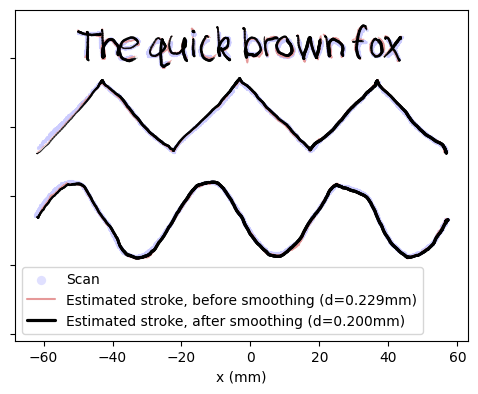

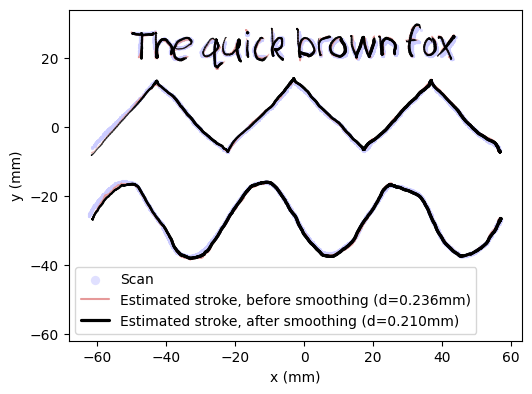

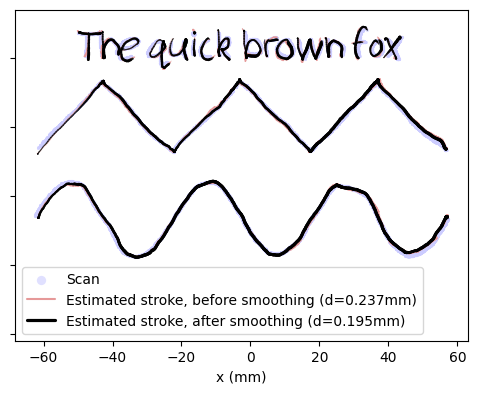

In [62]:
%matplotlib inline

mini_plot(*nomarkercalib)
plt.savefig(f"./recordings/{recording_timestamp}/nomarkercalib.pdf", **savefig_kwargs)

mini_plot(*norsc, noleftlabels=True)
plt.savefig(f"./recordings/{recording_timestamp}/norsc.pdf", **savefig_kwargs)

mini_plot(*epnp)
plt.savefig(f"./recordings/{recording_timestamp}/epnp.pdf", **savefig_kwargs)

mini_plot(*sqpnp, noleftlabels=True)
plt.savefig(f"./recordings/{recording_timestamp}/sqpnp.pdf", **savefig_kwargs)

In [ ]:
# nomarkercalib = load_and_process("stylus_data.pkl", "camera_data_nomarkercalib.pkl")

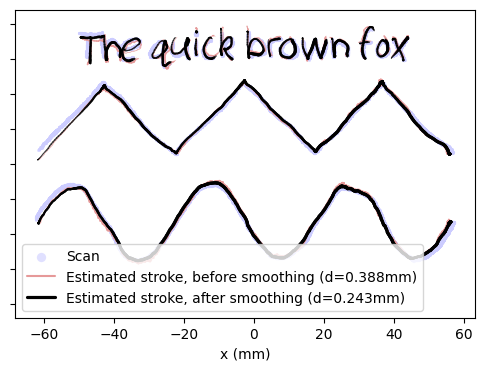

In [54]:
ax = mini_plot(*nomarkercalib, noleftlabels=True)
# ax.set(ylabel=None, yticklabels=[])
# plt.savefig(f"./recordings/{recording_timestamp}/nomarkercalib.pdf", **savefig_kwargs)